In [1]:
import pandas as pd
import numpy as np

from qgrid import show_grid

from siuba import *
from plotnine import *

In [2]:
major_fields_raw = pd.read_excel(
    "./data/sed17-sr-tab012.xlsx",
    skiprows = 3
)


## Preprocessing

In [3]:
renamed = major_fields_raw.rename(columns = {"Field of study": "field"})

melted_majors = renamed.melt(id_vars = "field", var_name = "key")

major_fields = (
    melted_majors
    .assign(
        # note: Series.where replaces values when condition is false or nan
        #       e.g. Series.where(condition, to_replace_if_false_or_nan)
        year= _.key.replace("Unnamed", np.nan, regex = True),
        type=_.value.where(_.value.str.contains("Number|Percent"), np.nan),
        value=lambda d: pd.to_numeric(d.value, "coerce")
    )
    .assign(year=_.year.ffill(), type=_.type.ffill())
    .drop(columns = "key")
    .loc[_.value.notna()]
    # this is spread(_.type, _.value) in pandas --------
    # unstack to row-index: field, type. multi-column-index: value[Number, Percent]
    .pipe(_.set_index(["field", "year", "type"]).unstack(level = -1))
    # get rid of multi-column-index
    .pipe(_.reset_index(col_level = 1).droplevel(None, axis = 1))
    # make it so our columns don't have a "name"
    .pipe(_.rename_axis(columns = None))
)

major_fields

,field,year,Number,Percent
0,"Aerospace, aeronautical, and astronautical eng...",1987.0,142.0,0.4
1,"Aerospace, aeronautical, and astronautical eng...",1992.0,234.0,0.6
2,"Aerospace, aeronautical, and astronautical eng...",1997.0,273.0,0.6
3,"Aerospace, aeronautical, and astronautical eng...",2002.0,209.0,0.5
4,"Aerospace, aeronautical, and astronautical eng...",2007.0,267.0,0.6
...,...,...,...,...
310,Unknown field,1997.0,1.0,NaN
311,Unknown field,2002.0,0.0,0.0
312,Unknown field,2007.0,3.0,NaN
313,Unknown field,2012.0,0.0,0.0


In [4]:
fine_fields = (
    pd.read_excel("./data/sed17-sr-tab013.xlsx", skiprows=3)
    .rename(columns = {"Fine field of study": "field"})
    .melt(id_vars = "field", var_name = "year", value_name = "number")
    # warning: can't index like below if our index has nans
    .loc[_.number != 'na']
    .assign(
        field = _.field.str.strip(),
        year = _.year.astype(float), 
        number = _.number.astype(float)        
    )
)

fine_fields

,field,year,number
0,All fields,2008.0,48777.0
1,Life sciences,2008.0,11086.0
2,Agricultural sciences and natural resources,2008.0,1198.0
3,Agricultural economics,2008.0,111.0
4,Agricultural and horticultural plant breeding,2008.0,28.0
...,...,...,...
3825,"Parks, sports, recreation, leisure and fitness",2017.0,49.0
3826,Public administration,2017.0,185.0
3827,Social work,2017.0,298.0
3828,Other fields nec,2017.0,103.0


## Plotting degrees over time for 6 degrees

In [5]:
# investigated why a space was there
ceramics = fine_fields >> filter(_.field.str.startswith("Ceramic"))
ceramics.values[0]



array(['Ceramic sciences engineering', 2008.0, 7.0], dtype=object)

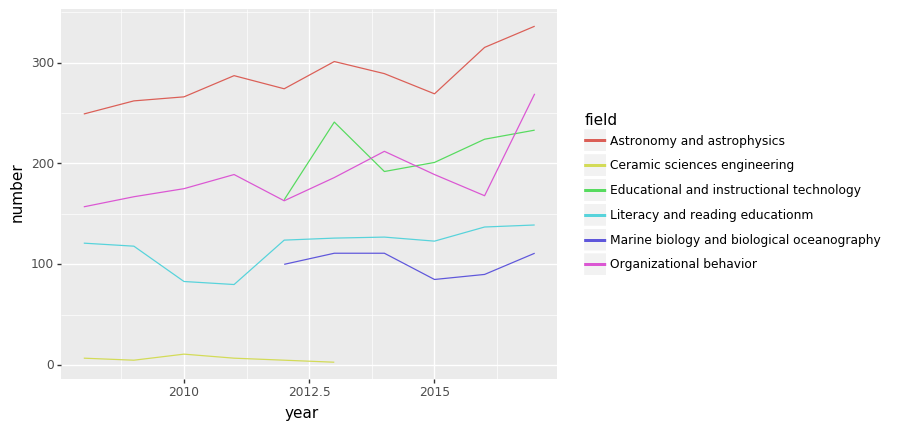

<ggplot: (-9223372036551542254)>

In [6]:
from random import sample

#field_subset = sample(list(fine_fields.field.unique()), 6)

field_subset = ['Marine biology and biological oceanography',
 'Educational and instructional technology',
 'Astronomy and astrophysics',
 'Organizational behavior',
 'Literacy and reading educationm',
 'Ceramic sciences engineering']

(
    fine_fields
    .loc[_.field.isin(field_subset)]
    >> ggplot(aes("year", "number", color="field"))
     + geom_line()
)

In [7]:
sex = ["All", "Male", "Female", "All doctorate recipientsa", "All fieldsa"]

broad_fields_raw = pd.read_excel("./data/sed17-sr-tab014.xlsx", skiprows=4)

broad_fields_formatted = (
    broad_fields_raw
    .rename(columns = {"Unnamed: 0": "field"})
    .loc[~_.field.isin(sex)]
    .assign(
        field=_.field.rename({
            "Life sciencesb": "Life sciences",
            "Otherc": "Other"
        })
    )
)

broad_fields = broad_fields_formatted.field

broad_fields

3                           Life sciencesb
6     Physical sciences and earth sciences
9        Mathematics and computer sciences
12          Psychology and social sciences
15                             Engineering
18                               Education
21                     Humanities and arts
24                                  Otherc
Name: field, dtype: object

In [8]:
recipients_year_field_sex_raw = pd.read_excel("./data/sed17-sr-tab015.xlsx", skiprows=3)
recipients_year_field_sex_raw.columns = recipients_year_field_sex_raw.columns.map(str)


recipients_year_field_sex = (
    recipients_year_field_sex_raw
    .rename(columns = {"Sex and major field of study": "field"})
    .loc[:,~_.columns.str.contains("change")]
    .assign(
        field=_.field.replace({
            "All doctorate recipientsa": "All",
            "Otherb": "Other"
            }),
        sex=_.field.where(_.field.isin(["Male", "Female", "All"])),
        broad_field= _.field.where(_.field.isin(broad_fields))
    )
    .assign(sex = _.sex.ffill(), broad_field = _.broad_field.ffill())
    .melt(id_vars = ["sex", "broad_field", "field"], var_name = "year", value_name = "number")
    .loc[(~_.field.isin(sex)) & _.number.notna()]
    .assign(year = _.year.astype(int))
)

recipients_year_field_sex

,sex,broad_field,field,year,number
1,All,NaN,Life sciences,2008,11086
2,All,NaN,Agricultural sciences and natural resources,2008,1198
3,All,NaN,Biological and biomedical sciences,2008,7797
4,All,NaN,Health sciences,2008,2091
5,All,Physical sciences and earth sciences,Physical sciences and earth sciences,2008,4946
...,...,...,...,...,...
1345,Female,Humanities and arts,Other,2017,1713
1346,Female,Humanities and arts,Business management and administration,2017,675
1347,Female,Humanities and arts,Communication,2017,428
1348,Female,Humanities and arts,Non-S&E fields nec,2017,610


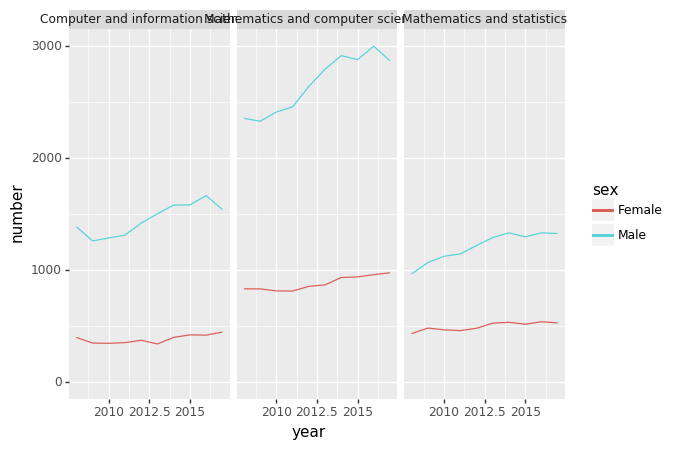

<ggplot: (-9223372036572812400)>

In [9]:
(
    recipients_year_field_sex
    >> filter(_.sex != "All", _.broad_field == "Mathematics and computer sciences")
    >> ggplot(aes("year", "number", color="sex"))
    + geom_line()
    + expand_limits(y=0)
    + facet_wrap("~ field")
)

In [10]:
from siuba.dply.forcats import fct_reorder


example = (    recipients_year_field_sex
    >> spread(_.sex, _.number)
    >> mutate(pct_male=_.Male / _.All)
    >> filter(_.broad_field == "Engineering")
)

fct_reorder(example.field, -example.pct_male)

[Aerospace, aeronautical, and astronautical eng..., Aerospace, aeronautical, and astronautical eng..., Aerospace, aeronautical, and astronautical eng..., Aerospace, aeronautical, and astronautical eng..., Aerospace, aeronautical, and astronautical eng..., ..., Other engineering, Other engineering, Other engineering, Other engineering, Other engineering]
Length: 100
Categories (10, object): [Mechanical engineering, Aerospace, aeronautical, and astronautical eng..., Electrical, electronics, and communications en..., Other engineering, ..., Materials science engineering, Industrial and manufacturing engineering, Chemical engineering, Bioengineering and biomedical engineering]

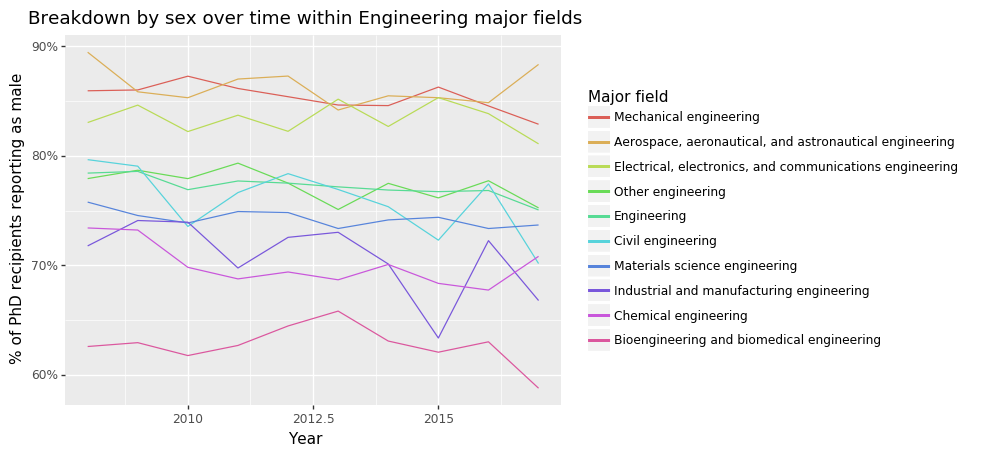

<ggplot: (-9223372036549349667)>

In [11]:
(
    recipients_year_field_sex
    # this is spread(_.type, _.value) in pandas --------
    # unstack to row-index: field, type. multi-column-index: value[Number, Percent]
    .pipe(_.set_index(["broad_field", "field", "year", "sex"]).unstack(level = -1))
    # get rid of multi-column-index
    .pipe(_.reset_index(col_level = 1).droplevel(None, axis = 1))
    # make it so our columns don't have a "name"
    .pipe(_.rename_axis(columns = None))
    # rest of pipe ----
    .assign(pct_male=_.Male / _.All)
    .loc[_.broad_field == "Engineering"]
    .assign(field = fct_reorder(_.field, -_.pct_male))
    >> ggplot(aes("year", "pct_male", color="field"))
    + geom_line()
    + scale_y_continuous(labels=lambda l: ["{:.0f}%".format(v * 100) for v in l])
    + labs(
        x="Year",
        y="% of PhD recipients reporting as male",
        color="Major field",
        title="Breakdown by sex over time within Engineering major fields",
    )
)

/Users/machow/.virtualenvs/tidytuesday-py/lib/python3.6/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 41 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)


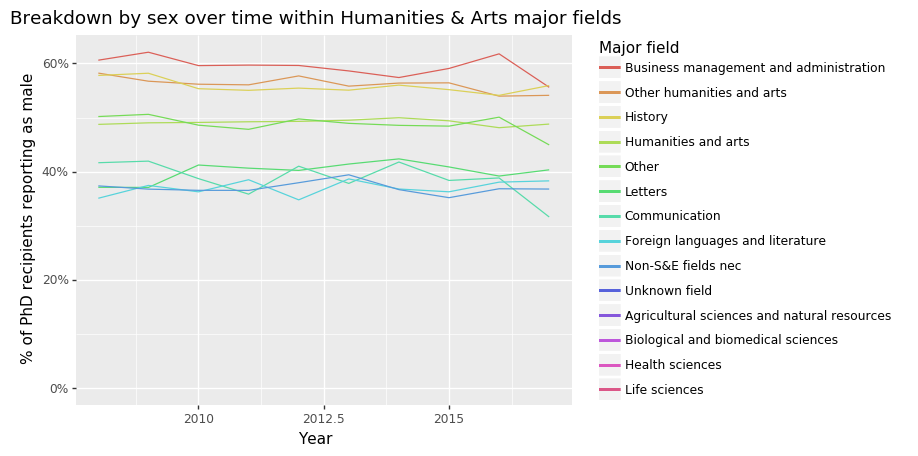

<ggplot: (-9223372036549426779)>

In [12]:
(
    recipients_year_field_sex
    >> spread(_.sex, _.number)
    >> mutate(pct_male=_.Male / _.All)
    >> filter(_.broad_field == "Humanities and arts")
    >> mutate(field = fct_reorder(_.field, -_.pct_male))
    >> ggplot(aes("year", "pct_male", color="field"))
    + geom_line()
    + scale_y_continuous(labels=lambda l: ["{:.0f}%".format(v * 100) for v in l])
    + labs(
        x="Year",
        y="% of PhD recipients reporting as male",
        color="Major field",
        title="Breakdown by sex over time within Humanities & Arts major fields",
    )
)

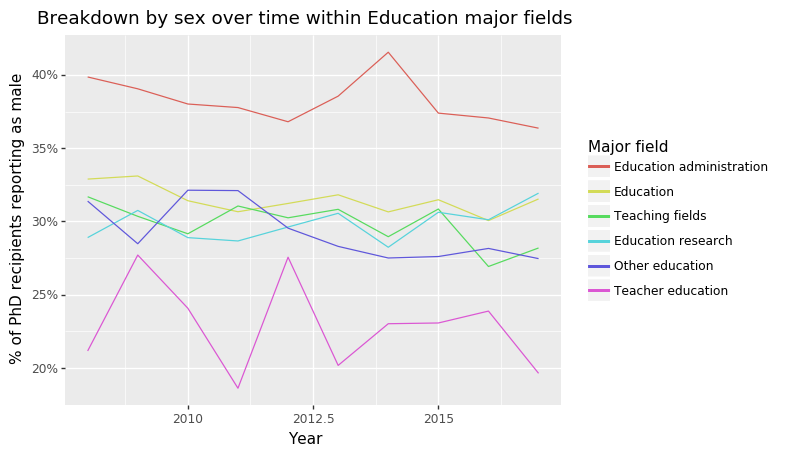

<ggplot: (-9223372036549290366)>

In [13]:
(
    recipients_year_field_sex
    >> spread(_.sex, _.number)
    >> mutate(pct_male=_.Male / _.All)
    >> filter(_.broad_field == "Education")
    >> mutate(field = fct_reorder(_.field, -_.pct_male))
    >> ggplot(aes("year", "pct_male", color="field"))
    + geom_line()
    + scale_y_continuous(labels=lambda l: ["{:.0f}%".format(v * 100) for v in l])
    + labs(
        x="Year",
        y="% of PhD recipients reporting as male",
        color="Major field",
        title="Breakdown by sex over time within Education major fields",
    )
)